In [1]:
#Import Packages
import os
import pandas as pd
import numpy as np

#Change Working Directory
os.chdir(r'C:\Users\malva\Thesis')

#Read data file
data = pd.read_csv('Files\Samples\ValdAran_Sample_5391.csv')
data.head()

,lat,long,elevation,slope,aspect,curv_plan,curv_prof,facc,twi,soil,lulc,rain_ant,rain_event,pof_event,pof_dry,pof_sat,response
0,4738872.5,311597.5,790.80,13.145604,327.05750,0.025769,-0.010359,1.397940,4.673251,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
1,4738862.5,311617.5,794.77,18.441340,307.93506,-0.117006,-0.044545,2.352183,6.514342,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
2,4738697.5,319872.5,1709.36,43.968290,173.81042,0.000644,0.018706,2.889302,6.688886,8.0,1.0,0.5,70.0,0.8803,0.3543,0.1197,1.0
3,4737832.5,318912.5,1285.22,47.644943,194.89754,0.076285,0.069331,0.000000,-11.605381,8.0,1.0,0.5,69.0,0.6894,0.5387,0.1381,1.0
4,4737377.5,317017.5,1734.32,39.489166,182.85223,-0.000287,-0.003942,3.122216,7.382731,8.0,1.0,0.5,67.0,0.6695,0.0711,0.3305,1.0


In [2]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
LULC: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0]


In [3]:
#Encoding Categorical with Pandas
X = pd.get_dummies(data, columns = ['soil', 'lulc'])
X = X.drop(columns=['lat', 'long', 'elevation', 'response'])

In [4]:
#Complete missing columns
X['lulc_7.0'] = 0
X['lulc_10.0'] = 0
X.sort_index(axis=1, inplace=True)
X.columns

Index(['aspect', 'curv_plan', 'curv_prof', 'facc', 'lulc_1.0', 'lulc_10.0',
       'lulc_2.0', 'lulc_3.0', 'lulc_4.0', 'lulc_5.0', 'lulc_6.0', 'lulc_7.0',
       'lulc_8.0', 'lulc_9.0', 'pof_dry', 'pof_event', 'pof_sat', 'rain_ant',
       'rain_event', 'slope', 'soil_1.0', 'soil_10.0', 'soil_11.0', 'soil_2.0',
       'soil_3.0', 'soil_4.0', 'soil_5.0', 'soil_6.0', 'soil_7.0', 'soil_8.0',
       'soil_9.0', 'twi'],
      dtype='object')

In [5]:
#Create inputs and outputs for the data-driven model
y = data['response'].values

In [6]:
#Import model as Pickle
import pickle

pkl_filename = 'Files\Models\logreg_norain.pkl'
logreg_norain = pickle.load(open(pkl_filename, 'rb'))

pkl_filename = 'Files\Models\logreg_rain.pkl'
logreg_rain = pickle.load(open(pkl_filename, 'rb'))

In [7]:
#Predict Probabilities
y_pred_prob_logreg_norain = logreg_norain.predict_proba(X.drop(columns=['rain_ant', 'rain_event', 'pof_dry', 'pof_event', 'pof_sat']))[:, 1]
print(y_pred_prob_logreg_norain.shape)

y_pred_prob_logreg_rain = logreg_rain.predict_proba(X.drop(columns=['pof_dry', 'pof_event', 'pof_sat']))[:, 1]
print(y_pred_prob_logreg_rain.shape)

y_pred_prob_fslam_dry = X['pof_dry'].values
y_pred_prob_fslam = y_pred_prob_fslam_dry.reshape(-1, 1)
print(y_pred_prob_fslam_dry.shape)

y_pred_prob_fslam_event = X['pof_event'].values
y_pred_prob_fslam_event = y_pred_prob_fslam_event.reshape(-1, 1)
print(y_pred_prob_fslam_event.shape)

(5391,)
(5391,)
(5391,)
(5391, 1)


In [8]:
#Summary Statistics
from scipy import stats

summary_logreg = stats.describe(y_pred_prob_logreg_norain)
summary = pd.DataFrame(columns=summary_logreg._fields)

summary.loc['logreg_norain'] = stats.describe(y_pred_prob_logreg_norain)
summary.loc['logreg_rain'] = stats.describe(y_pred_prob_logreg_rain)
summary.loc['fslam_dry'] = stats.describe(y_pred_prob_fslam_dry)
summary.loc['fslam_event'] = stats.describe(y_pred_prob_fslam_event)

print(summary.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  nobs &                                       minmax &                  mean &              variance &              skewness &               kurtosis \\
\midrule
logreg\_norain &  5391 &   (0.021441830592389667, 0.9206929805032259) &              0.401415 &              0.046557 &              0.266344 &              -0.912065 \\
logreg\_rain   &  5391 &  (0.0006469160829423024, 0.9957079407883002) &              0.385905 &               0.06227 &              0.391889 &              -0.899449 \\
fslam\_dry     &  5391 &                                   (0.0, 1.0) &              0.135513 &               0.07778 &              2.205106 &               3.532209 \\
fslam\_event   &  5391 &                               ([0.0], [1.0]) &  [0.3398535893155259] &  [0.1602874971666135] &  [0.6915961769458101] &  [-1.2318848748860969] \\
\bottomrule
\end{tabular}



In [9]:
#Medians
print('Logreg No Rain: ' + str(np.median(y_pred_prob_logreg_norain)))
print('Logreg Rain: ' + str(np.median(y_pred_prob_logreg_rain)))
print('FSLAM Dry: ' + str(np.median(y_pred_prob_fslam_dry)))
print('FSLAM Event: ' + str(np.median(y_pred_prob_fslam_event)))

Logreg No Rain: 0.3793703464937427
Logreg Rain: 0.35077444111889927
FSLAM Dry: 0.0011
FSLAM Event: 0.1008


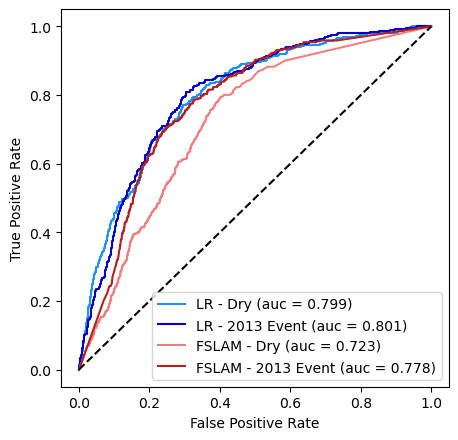

In [12]:
#Calculate Metrics

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#No Rain Logistic Regression
fpr_logreg_norain, tpr_logreg_norain, thresholds_logreg_norain = metrics.roc_curve(y, y_pred_prob_logreg_norain)
auc_logreg_norain = metrics.roc_auc_score(y, y_pred_prob_logreg_norain)

#Rain Logistic Regression
fpr_logreg_rain, tpr_logreg_rain, thresholds_logreg_rain = metrics.roc_curve(y, y_pred_prob_logreg_rain)
auc_logreg_rain = metrics.roc_auc_score(y, y_pred_prob_logreg_rain)

#FSLAM Dry
fpr_fslam_dry, tpr_fslam_dry, thresholds_fslam_dry = metrics.roc_curve(y, y_pred_prob_fslam_dry)
auc_fslam_dry = metrics.roc_auc_score(y, y_pred_prob_fslam_dry)

#FSLAM Event
fpr_fslam_event, tpr_fslam_event, thresholds_fslam_event = metrics.roc_curve(y, y_pred_prob_fslam_event)
auc_fslam_event = metrics.roc_auc_score(y, y_pred_prob_fslam_event)

#Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr_logreg_norain, tpr_logreg_norain, marker='', color='dodgerblue', label='LR - Dry (auc = %0.3f)' % auc_logreg_norain)
plt.plot(fpr_logreg_rain, tpr_logreg_rain, marker='', color='mediumblue', label='LR - 2013 Event (auc = %0.3f)' % auc_logreg_rain)
plt.plot(fpr_fslam_dry, tpr_fslam_dry, marker='', color='lightcoral', label='FSLAM - Dry (auc = %0.3f)' % auc_fslam_dry)
plt.plot(fpr_fslam_event, tpr_fslam_event, marker='', color='firebrick', label='FSLAM - 2013 Event (auc = %0.3f)' % auc_fslam_event)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig(r'C:\Users\malva\Desktop\Test\logistic-fslam-5391.png', bbox_inches = 'tight', facecolor='white', edgecolor='white', dpi=300)
plt.show()

In [13]:
#Transpose
y_pred_prob_fslam_dry = y_pred_prob_fslam_dry.reshape(-1, 1)
y_pred_prob_fslam_event = y_pred_prob_fslam_event.reshape(-1, 1)
y_pred_prob_logreg_norain = y_pred_prob_logreg_norain.reshape(-1, 1)
y_pred_prob_logreg_rain = y_pred_prob_logreg_rain.reshape(-1, 1)

#Thresholds
thresholds = np.linspace(0.05, 0.95, 20, endpoint = True)

In [14]:
#Accuracy and MCC across all thresholds
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, matthews_corrcoef

#Balanced Accuracy
accuracy_fslam_dry = []
accuracy_fslam_event = []
accuracy_logreg_norain = []
accuracy_logreg_rain = []

#FPR
fpr_fslam_dry = []
fpr_fslam_event = []
fpr_logreg_norain = []
fpr_logreg_rain = []

#FNR
fnr_fslam_dry = []
fnr_fslam_event = []
fnr_logreg_norain = []
fnr_logreg_rain = []

#MCC
mcc_fslam_dry = []
mcc_fslam_event = []
mcc_logreg_norain = []
mcc_logreg_rain = []

#Logistic Regression
for i in thresholds:
    y_pred_class_logreg_norain = binarize(y_pred_prob_logreg_norain, threshold=i)
    y_pred_class_logreg_rain = binarize(y_pred_prob_logreg_rain, threshold=i)
    
    #Balanced Accuracy
    accuracy_logreg_norain.append(balanced_accuracy_score(y, y_pred_class_logreg_norain))
    accuracy_logreg_rain.append(balanced_accuracy_score(y, y_pred_class_logreg_rain))
    #FPR
    matrix_norain = confusion_matrix(y, y_pred_class_logreg_norain)
    FP = matrix_norain[0,1]
    TN = matrix_norain[0,0]
    fpr_logreg_norain.append(FP/(FP+TN))
    matrix_rain = confusion_matrix(y, y_pred_class_logreg_rain)
    FP = matrix_norain[0,1]
    TN = matrix_norain[0,0]
    fpr_logreg_rain.append(FP/(FP+TN))
    #FNR
    fnr_logreg_norain.append(1 - recall_score(y, y_pred_class_logreg_norain))
    fnr_logreg_rain.append(1 - recall_score(y, y_pred_class_logreg_rain))
    #MCC
    mcc_logreg_norain.append(matthews_corrcoef(y, y_pred_class_logreg_norain))
    mcc_logreg_rain.append(matthews_corrcoef(y, y_pred_class_logreg_rain))
    
#FSLAM
for j in thresholds:
    y_pred_class_fslam_dry = binarize(y_pred_prob_fslam_dry, threshold=j)
    y_pred_class_fslam_event = binarize(y_pred_prob_fslam_event, threshold=j)
    
    #Balanced Accuracy
    accuracy_fslam_dry.append(balanced_accuracy_score(y, y_pred_class_fslam_dry))
    accuracy_fslam_event.append(balanced_accuracy_score(y, y_pred_class_fslam_event))
    #FPR
    matrix_dry = confusion_matrix(y, y_pred_class_fslam_dry)
    FP = matrix_dry[0,1]
    TN = matrix_dry[0,0]
    fpr_fslam_dry.append(FP/(FP+TN))
    matrix_event = confusion_matrix(y, y_pred_class_fslam_event)
    FP = matrix_dry[0,1]
    TN = matrix_dry[0,0]
    fpr_fslam_event.append(FP/(FP+TN))
    #FNR
    fnr_fslam_dry.append(1 - recall_score(y, y_pred_class_fslam_dry))
    fnr_fslam_event.append(1 - recall_score(y, y_pred_class_fslam_event))
    #MCC
    mcc_fslam_dry.append(matthews_corrcoef(y, y_pred_class_fslam_dry))
    mcc_fslam_event.append(matthews_corrcoef(y, y_pred_class_fslam_event))

C:\anaconda3\envs\geo_py38\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


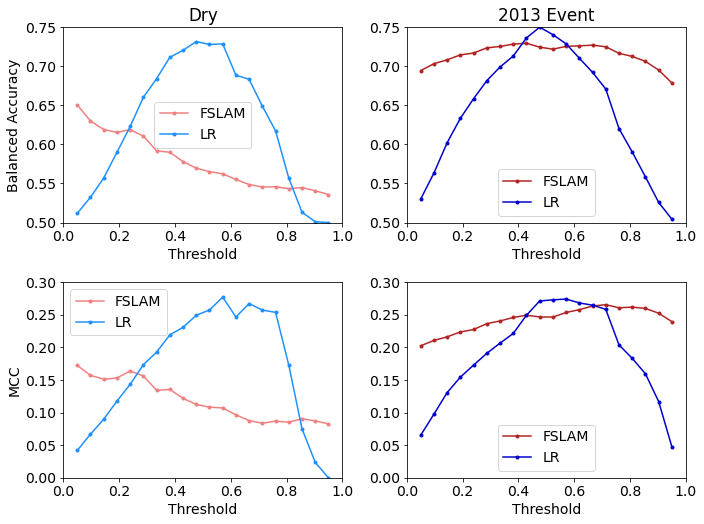

In [17]:
#Plot Accuracy and MCC
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7.5))

#No Rain
ax[0,0].plot(thresholds, accuracy_fslam_dry, marker='.', color='lightcoral', label='FSLAM')
ax[0,0].plot(thresholds, accuracy_logreg_norain, marker='.', color='dodgerblue', label='LR')
ax[0,0].set_ylim(0.5,0.75)
ax[0,0].set_title('Dry')
ax[0,0].set_xlabel('Threshold')
ax[0,0].set_ylabel('Balanced Accuracy')
ax[0,0].legend()
ax[0,0].set_xlim([0, 1])
ax[1,0].plot(thresholds, mcc_fslam_dry, marker='.', color='lightcoral', label='FSLAM')
ax[1,0].plot(thresholds, mcc_logreg_norain, marker='.', color='dodgerblue', label='LR')
ax[1,0].set_ylim(0,0.3)
ax[1,0].set_xlabel('Threshold')
ax[1,0].set_ylabel('MCC')
ax[1,0].legend()
ax[1,0].set_xlim([0, 1])

#Rain
ax[0,1].plot(thresholds, accuracy_fslam_event, marker='.', color='firebrick', label='FSLAM')
ax[0,1].plot(thresholds, accuracy_logreg_rain, marker='.', color='mediumblue', label='LR')
ax[0,1].set_title('2013 Event')
ax[0,1].set_xlabel('Threshold')
ax[0,1].set_ylim(0.5,0.75)
ax[0,1].legend()
ax[0,1].set_xlim([0, 1])
ax[1,1].plot(thresholds, mcc_fslam_event, marker='.', color='firebrick', label='FSLAM')
ax[1,1].plot(thresholds, mcc_logreg_rain, marker='.', color='mediumblue', label='LR')
ax[1,1].set_ylim(0,0.3)
ax[1,1].set_xlabel('Threshold')
ax[1,1].legend()
ax[1,1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\logistic-FSLAM-acc-mcc.png', bbox_inches = 'tight', facecolor='white', edgecolor='white', dpi=300)
plt.show()

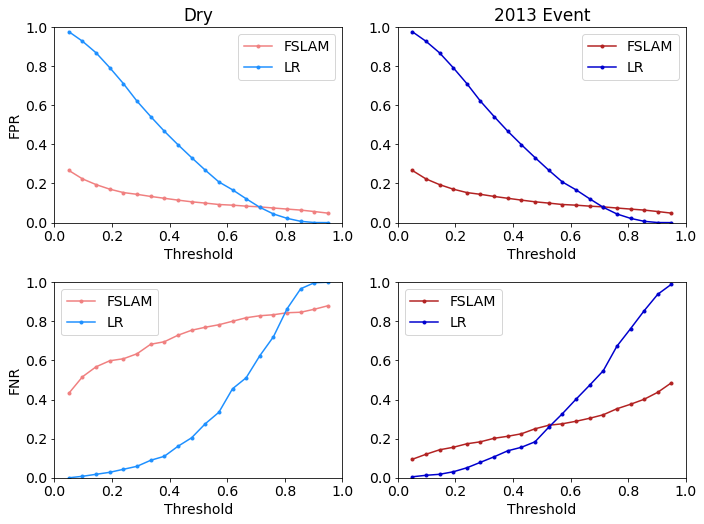

In [19]:
#Plot FPR FNR
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7.5))

#No Rain
ax[0,0].plot(thresholds, fpr_fslam_dry, marker='.', color='lightcoral', label='FSLAM')
ax[0,0].plot(thresholds, fpr_logreg_norain, marker='.', color='dodgerblue', label='LR')
ax[0,0].set_ylim(0,1)
ax[0,0].set_title('Dry')
ax[0,0].set_xlabel('Threshold')
ax[0,0].set_ylabel('FPR')
ax[0,0].legend()
ax[0,0].set_xlim([0, 1])
ax[1,0].plot(thresholds, fnr_fslam_dry, marker='.', color='lightcoral', label='FSLAM')
ax[1,0].plot(thresholds, fnr_logreg_norain, marker='.', color='dodgerblue', label='LR')
ax[1,0].set_ylim(0,1)
ax[1,0].set_xlabel('Threshold')
ax[1,0].set_ylabel('FNR')
ax[1,0].legend()
ax[1,0].set_xlim([0, 1])

#Rain
ax[0,1].plot(thresholds, fpr_fslam_event, marker='.', color='firebrick', label='FSLAM')
ax[0,1].plot(thresholds, fpr_logreg_rain, marker='.', color='mediumblue', label='LR')
ax[0,1].set_title('2013 Event')
ax[0,1].set_xlabel('Threshold')
ax[0,1].set_ylim(0,1)
ax[0,1].legend()
ax[0,1].set_xlim([0, 1])
ax[1,1].plot(thresholds, fnr_fslam_event, marker='.', color='firebrick', label='FSLAM')
ax[1,1].plot(thresholds, fnr_logreg_rain, marker='.', color='mediumblue', label='LR')
ax[1,1].set_ylim(0,1)
ax[1,1].set_xlabel('Threshold')
ax[1,1].legend()
ax[1,1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\logistic-FSLAM-fpr-fnr.png', bbox_inches = 'tight', facecolor='white', edgecolor='white', dpi=300)
plt.show()

In [20]:
#Collect Results
results = pd.DataFrame()
results['response'] = data['response']
results['Logreg No Rain'] = y_pred_prob_logreg_norain
results['Logreg Rain'] = y_pred_prob_logreg_rain
results['FSLAM Dry'] = y_pred_prob_fslam_dry
results['FSLAM Event'] = y_pred_prob_fslam_event

#Separate into Inventory and Random Points
inventory_points = results[results['response'] == 1]
random_points = results[results['response'] == 0]

In [21]:
#Histograms
hist_bins = np.linspace(0, 1, 21)
np_bins = np.concatenate((np.array([0]), np.linspace(0.025, 0.975, 20), np.array([1])), axis=None)

count_inventory_logreg_norain = np.histogram(inventory_points['Logreg No Rain'], bins = np_bins)[0]
count_inventory_logreg_rain = np.histogram(inventory_points['Logreg Rain'], bins = np_bins)[0]
count_inventory_fslam_dry = np.histogram(inventory_points['FSLAM Dry'], bins = np_bins)[0]
count_inventory_fslam_event = np.histogram(inventory_points['FSLAM Event'], bins = np_bins)[0]

count_random_logreg_norain = np.histogram(random_points['Logreg No Rain'], bins = np_bins)[0]
count_random_logreg_rain = np.histogram(random_points['Logreg Rain'], bins = np_bins)[0]
count_random_fslam_dry = np.histogram(random_points['FSLAM Dry'], bins = np_bins)[0]
count_random_fslam_event = np.histogram(random_points['FSLAM Event'], bins = np_bins)[0]

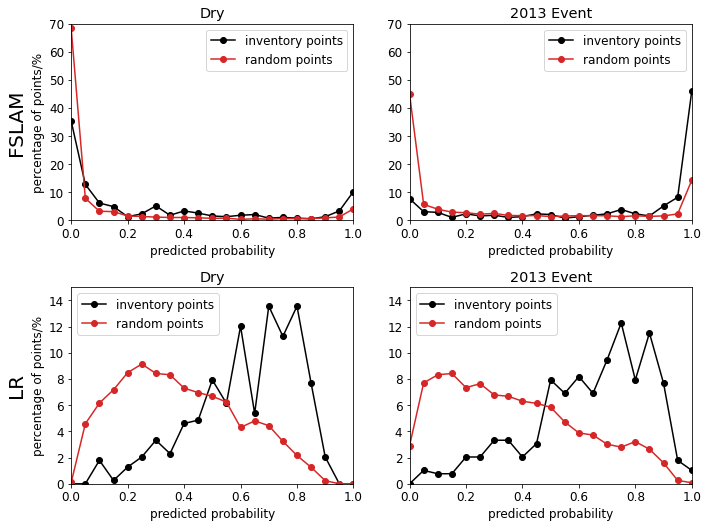

In [22]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7.5))

#No Rain
axes[0,0].plot(hist_bins, (count_inventory_fslam_dry/np.sum(count_inventory_fslam_dry))*100, marker='o', color='black', label='inventory points')
axes[0,0].plot(hist_bins, (count_random_fslam_dry/np.sum(count_random_fslam_dry))*100, marker='o', color='tab:red', label='random points')
axes[0,0].set_ylim(0,70)
axes[0,0].set_title('Dry')
axes[0,0].set_xlabel('predicted probability')
axes[0,0].set_ylabel('percentage of points/%')
axes[0,0].legend()
axes[0,0].set_xlim([0, 1])
axes[1,0].plot(hist_bins, (count_inventory_logreg_norain/np.sum(count_inventory_logreg_norain))*100, marker='o', color='black', label='inventory points')
axes[1,0].plot(hist_bins, (count_random_logreg_norain/np.sum(count_random_logreg_norain))*100, marker='o', color='tab:red', label='random points')
axes[1,0].set_ylim(0,15)
axes[1,0].set_title('Dry')
axes[1,0].set_xlabel('predicted probability')
axes[1,0].set_ylabel('percentage of points/%')
axes[1,0].legend()
axes[1,0].set_xlim([0, 1])

#Rain
axes[0,1].plot(hist_bins, (count_inventory_fslam_event/np.sum(count_inventory_fslam_event))*100, marker='o', color='black', label='inventory points')
axes[0,1].plot(hist_bins, (count_random_fslam_event/np.sum(count_random_fslam_event))*100, marker='o', color='tab:red', label='random points')
axes[0,1].set_ylim(0,70)
axes[0,1].set_title('2013 Event')
axes[0,1].set_xlabel('predicted probability')
axes[0,1].legend()
axes[0,1].set_xlim([0, 1])
axes[1,1].plot(hist_bins, (count_inventory_logreg_rain/np.sum(count_inventory_logreg_rain))*100, marker='o', color='black', label='inventory points')
axes[1,1].plot(hist_bins, (count_random_logreg_rain/np.sum(count_random_logreg_rain))*100, marker='o', color='tab:red', label='random points')
axes[1,1].set_ylim(0,15)
axes[1,1].set_title('2013 Event')
axes[1,1].set_xlabel('predicted probability')
axes[1,1].legend()
axes[1,1].set_xlim([0, 1])

for ax, row in zip(axes[:,0], ['FSLAM', 'LR']):
    ax.annotate(row, (0, 0.5), xytext=(-45, 0), ha='right', va='center',
                size=20, rotation=90, xycoords='axes fraction',
                textcoords='offset points')

plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\histograms-fslam-logreg.png', bbox_inches = 'tight', facecolor='white', edgecolor='white', dpi=300)
plt.show()